In [160]:
from utils.dataGenerator import dataGenerator
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
import os

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Author: Peter Bowman-Davis, Nov 20, 2023                          #
# Version 1 of Timeseries Prediction for Physical Systems Demo      #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

#Initialize OpenAI API Client

client = OpenAI(api_key='')


# Data Generation

In [161]:
# Define functions to be used
damped_harmonic_oscillator=lambda x: np.exp(-x)*np.sin(2*np.pi*x)
sine_wave=lambda x: np.sin(2*np.pi*x)

# Generate input sequence
dg=dataGenerator(t_max=3.33, samples=51, noise=0.15, fxn=sine_wave)
input=dg.generateStringOutput()

num_train=31

train=input.split(" ")[0:num_train]

test=input.split(" ")[num_train:]


### Train / Test Split

"Train" means the in-context tokens that will be fed to the LLM. "Test" will be used to evaluate MAE in the data analysis stage.

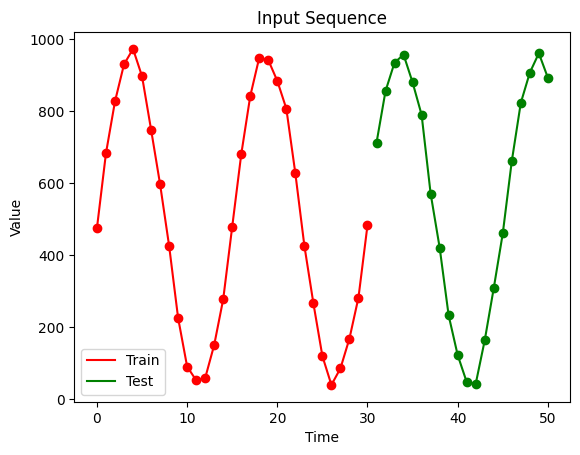

In [162]:
plt.plot(range(0,num_train),[int(y) for y in input.split(" ")[0:num_train]], 'r',label="Train")
plt.plot(range(0,num_train),[int(y) for y in input.split(" ")[0:num_train]], 'ro')
plt.plot(range(num_train,num_train+len(input.split(" ")[num_train:])),[int(y) for y in input.split(" ")[num_train:]], 'g',label="Test")
plt.plot(range(num_train,num_train+len(input.split(" ")[num_train:])),[int(y) for y in input.split(" ")[num_train:]], 'go')
plt.title("Input Sequence")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [163]:
def genNextSequence(inputSeq,sysPrompt):
    sysPrompt=sysPrompt
    prompt=inputSeq

    completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": sysPrompt},
        {"role": "user", "content": prompt}
    ],
    max_tokens=50,
    n=100
    )
    return completion

### Prompts and Data Structure

In [164]:
suffix="Please continue the following sequence without producing any additional text, just return the next twenty numbers."
sysPrompts = {
    "NoInfoSineWave": "You are a helpful assistant that performs time series predictions. " + suffix,
    "sineWave": "You are a helpful assistant that performs time series predictions on a sinusoidal signal. " + suffix,
    "sineWavePhaseDescription": "You are a helpful assistant that performs time series predictions on a sinusoidal signal. " + suffix + "Generated values must progressively increase to start.",
}

dataByPrompt = { # Key: Prompt, Value: List of Lists of generated samples
    "NoInfo": [],
    "UHO": [],
}

### GPT Call

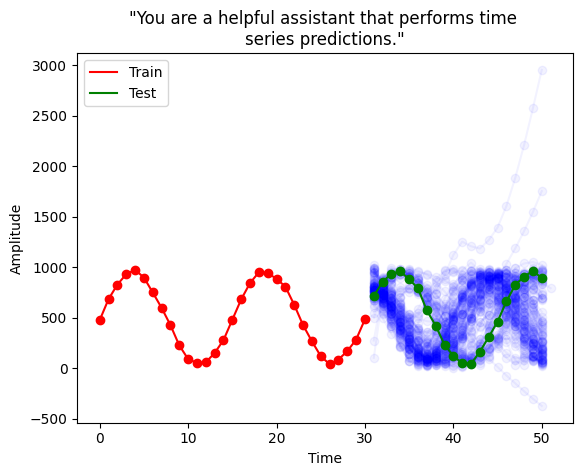

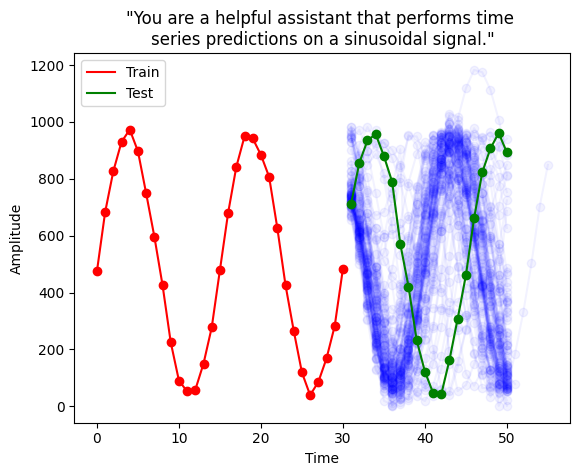

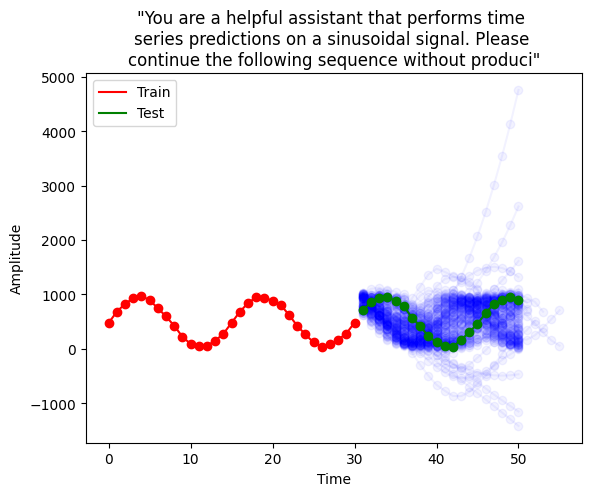

In [165]:
for sysPrompt in sysPrompts.values():
    
    plt.plot(range(0,len(train)),[int(y) for y in train], 'r',label="Train")
    plt.plot(range(0,len(train)),[int(y) for y in train], 'ro')

    generatedSamples=[]
    generatedSamples = []
    i = 0
    for message in genNextSequence(input, sysPrompt).choices:
        try: # Can't win them all – nonstandard response format intrinsic to LLMs requires some data cleaning
            generatedSample = [int(stringNumber) for stringNumber in message.message.content.split(" ") if stringNumber != "" and stringNumber != " "]
            generatedSamples.append(generatedSample)
            
            i += 1  
        except:
            pass

    validGeneratedSamples = []  # List to store only valid sequences

    for generatedSample in generatedSamples:
        if len(generatedSample) == 20:
            validGeneratedSamples.append(generatedSample)
            plt.plot(range(len(train), len(train) + len(generatedSample)), generatedSample, 'b', alpha=0.05)
            plt.plot(range(len(train), len(train) + len(generatedSample)), generatedSample, 'bo', alpha=0.05)
        elif len(generatedSample) > 20:
            truncatedSample = generatedSample[:20]  # Truncate to the first 20 elements
            validGeneratedSamples.append(truncatedSample)
            plt.plot(range(len(train), len(train) + len(generatedSample)), generatedSample, 'b', alpha=0.05)
            plt.plot(range(len(train), len(train) + len(generatedSample)), generatedSample, 'bo', alpha=0.05)
        
    
    generatedSamples = validGeneratedSamples

    dataByPrompt[sysPrompt] = generatedSamples


    for key, value in sysPrompts.items():
        if value == sysPrompt:
            sysPromptKey = key
            break
    
    if os.path.exists("./savedData/"+sysPromptKey + '.csv'):
        with open("./savedData/"+sysPromptKey + '.csv', 'a') as f:
            np.savetxt(f, generatedSamples, delimiter=',', fmt='%d')
    else:
        with open("./savedData/"+sysPromptKey + '.csv', 'w') as f:
            np.savetxt(f, generatedSamples, delimiter=',', fmt='%d')


    # Everything below here is just for plotting. 
   
    plt.plot(range(num_train,num_train+len(input.split(" ")[num_train:])),[int(y) for y in input.split(" ")[num_train:]], 'g',label="Test")
    plt.plot(range(num_train,num_train+len(input.split(" ")[num_train:])),[int(y) for y in input.split(" ")[num_train:]], 'go')
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

    
    displaytitle = sysPrompt[0:len(sysPrompt)-len(suffix)]
    
    # Format title to fit on plot
    if len(displaytitle) > 50:
        words = displaytitle.split()
        displaytitle = ""
        current_line = ""
        for word in words:
            if len(current_line) + len(word) <= 50:
                current_line += word + " "
            else:
                displaytitle += current_line + "\n"
                current_line = word + " "
        displaytitle += current_line
    displaytitle = displaytitle[0:len(displaytitle)-1]

    plt.title('"'+displaytitle+'"')
    plt.legend()
    plt.show()

    


### Data Cleaning

Successfully generated 98 samples for prompt "You are a helpful assistant that performs time series predictions. Please continue the following sequence without producing any additional text, just return the next twenty numbers."


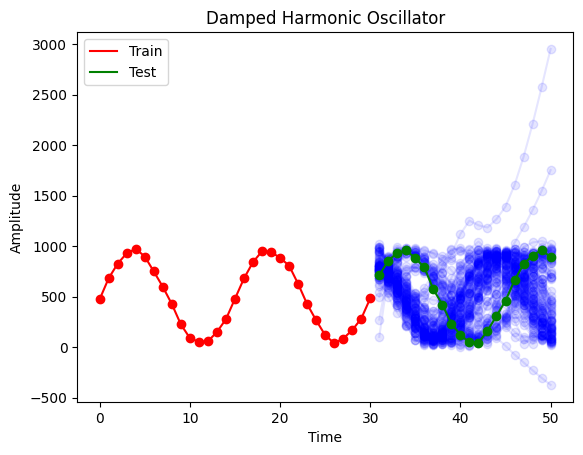

Successfully generated 93 samples for prompt "You are a helpful assistant that performs time series predictions on a sinusoidal signal. Please continue the following sequence without producing any additional text, just return the next twenty numbers."


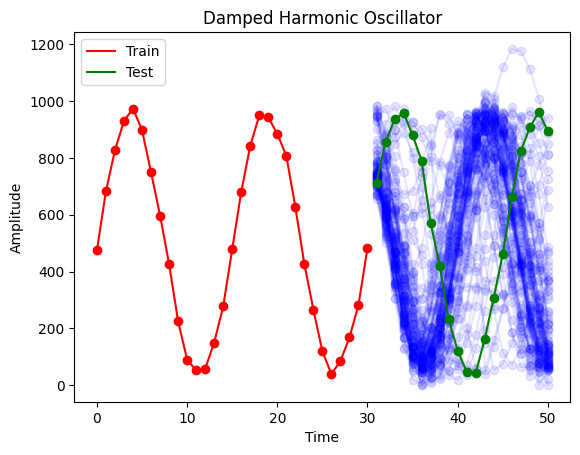

Successfully generated 97 samples for prompt "You are a helpful assistant that performs time series predictions on a sinusoidal signal. Please continue the following sequence without producing any additional text, just return the next twenty numbers.Generated values must progressively increase to start."


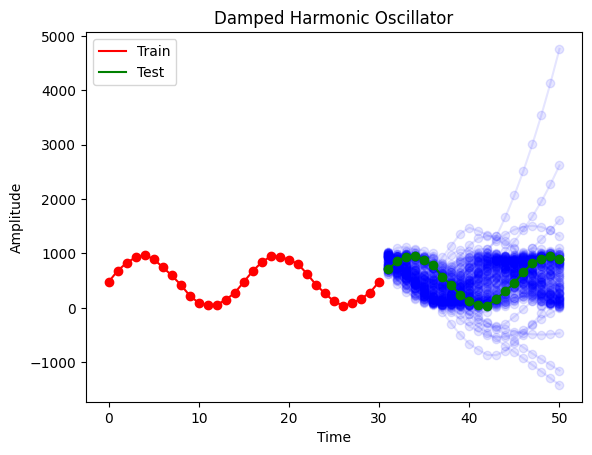

In [166]:
for sysPrompt in sysPrompts.values():
    generatedSamples = dataByPrompt[sysPrompt]
    
    print(f'Successfully generated {len(generatedSamples)} samples for prompt "{sysPrompt}"')

    plt.plot(range(0,len(train)),[int(y) for y in train], 'r',label="Train")
    plt.plot(range(0,len(train)),[int(y) for y in train], 'ro')

    for i in range(len(generatedSamples)):
        plt.plot(range(len(train), len(train) + len(generatedSamples[i])), generatedSamples[i], 'b', alpha=0.1)
        plt.plot(range(len(train), len(train) + len(generatedSamples[i])), generatedSamples[i], 'bo', alpha=0.1)

    plt.plot(range(num_train,num_train+len(input.split(" ")[num_train:])),[int(y) for y in input.split(" ")[num_train:]], 'g',label="Test")
    plt.plot(range(num_train,num_train+len(input.split(" ")[num_train:])),[int(y) for y in input.split(" ")[num_train:]], 'go')

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Damped Harmonic Oscillator")
    plt.legend()
    plt.show()



# Data Analysis

We will use a variety of metrics to assess the generated data.

1. MAE – most general descriptor
2. Fraction out of range (e.g has any data x>1000 || x< 0) 
3. Other attributes?

### MAE, MSE, Boundary Checking

[[806, 734, 597, 389, 209, 85, 58, 132, 248, 440, 656, 825, 922, 986, 927, 752, 561, 357, 154, 54], [550, 677, 724, 799, 790, 752, 687, 557, 376, 247, 142, 91, 82, 125, 215, 371, 556, 762, 912, 964], [785, 667, 521, 419, 364, 448, 596, 748, 919, 1120, 1252, 1206, 1184, 1267, 1392, 1604, 1883, 2209, 2572, 2952], [779, 697, 648, 707, 786, 870, 759, 736, 632, 554, 531, 606, 735, 725, 680, 614, 604, 646, 705, 679], [981, 852, 690, 498, 332, 200, 218, 336, 521, 715, 871, 963, 986, 934, 811, 631, 447, 296, 188, 132], [273, 755, 856, 964, 937, 890, 785, 623, 520, 351, 177, 61, 221, 371, 583, 648, 691, 855, 973, 968], [772, 643, 459, 255, 70, 26, 43, 147, 333, 542, 732, 865, 924, 912, 823, 663, 454, 236, 111, 60], [830, 765, 602, 399, 243, 167, 124, 154, 297, 488, 706, 828, 883, 863, 775, 644, 472, 286, 112, 23], [803, 732, 533, 376, 203, 109, 49, 102, 171, 288, 456, 656, 812, 900, 935, 907, 826, 703, 552, 388], [677, 813, 902, 934, 903, 846, 756, 630, 455, 252, 116, 84, 106, 192, 339, 521, 72

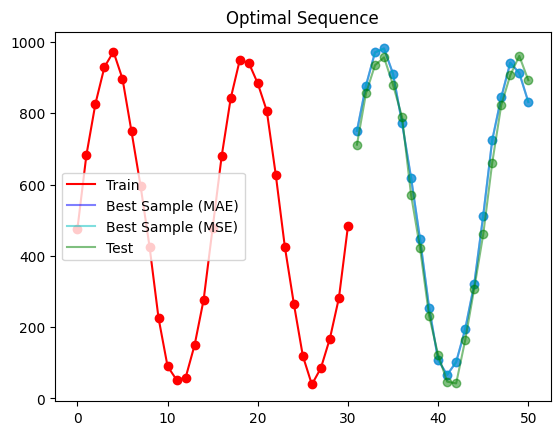

[[685, 801, 899, 954, 927, 872, 789, 670, 527, 369, 203, 62, 41, 136, 270, 457, 651, 813, 912, 941], [711, 597, 422, 216, 82, 60, 152, 289, 494, 722, 843, 898, 895, 837, 759, 564, 424, 239, 122, 74], [720, 637, 493, 313, 135, 70, 123, 288, 487, 673, 810, 896, 993, 928, 789, 614, 434, 272, 157, 93], [740, 617, 464, 284, 100, 61, 126, 248, 432, 620, 753, 859, 928, 926, 874, 793, 648, 451, 316, 215], [754, 652, 498, 315, 129, 83, 174, 323, 506, 672, 790, 840, 813, 710, 541, 349, 171, 70, 91, 215], [737, 574, 364, 166, 19, 6, 82, 238, 450, 654, 804, 912, 967, 879, 760, 599, 415, 229, 133, 60], [666, 531, 394, 242, 103, 101, 204, 328, 532, 737, 877, 954, 961, 886, 782, 605, 456, 271, 133, 55], [950, 831, 725, 671, 683, 768, 904, 105, 218, 380, 551, 721, 850, 931, 955, 914, 817, 676, 510, 346], [768, 648, 541, 488, 541, 651, 802, 955, 920, 773, 601, 402, 194, 53, 74, 147, 246, 395, 555, 724], [738, 614, 462, 291, 103, 2, 26, 126, 306, 471, 621, 756, 853, 904, 887, 807, 677, 505, 302, 94], [7

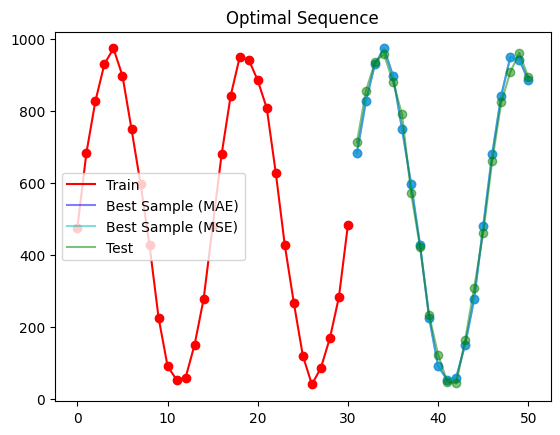

[[795, 725, 605, 445, 266, 94, 99, 171, 307, 507, 716, 860, 943, 957, 906, 800, 651, 484, 317, 166], [742, 657, 556, 446, 340, 237, 141, 54, -36, -119, -202, -276, -341, -395, -437, -468, -486, -492, -486, -468], [928, 769, 580, 372, 182, 72, 74, 187, 342, 519, 684, 800, 877, 859, 763, 622, 451, 265, 84, 7], [969, 849, 674, 479, 297, 169, 134, 215, 402, 633, 825, 915, 924, 856, 730, 572, 405, 263, 180, 180], [627, 809, 970, 976, 913, 771, 614, 444, 258, 58, -83, -69, 28, 202, 403, 611, 798, 951, 1014, 970], [943, 874, 726, 558, 381, 223, 115, 117, 219, 402, 596, 772, 900, 960, 929, 812, 632, 409, 194, 48], [625, 438, 295, 190, 131, 118, 151, 230, 355, 526, 743, 1006, 1315, 1670, 2071, 2518, 3011, 3549, 4133, 4762], [957, 954, 908, 819, 684, 510, 305, 96, 52, 182, 347, 502, 708, 835, 936, 977, 897, 771, 580, 365], [962, 809, 628, 421, 246, 157, 156, 230, 381, 574, 727, 820, 830, 760, 636, 484, 319, 161, 74, 94], [686, 828, 928, 976, 902, 754, 605, 426, 223, 100, 52, 59, 142, 280, 472, 6

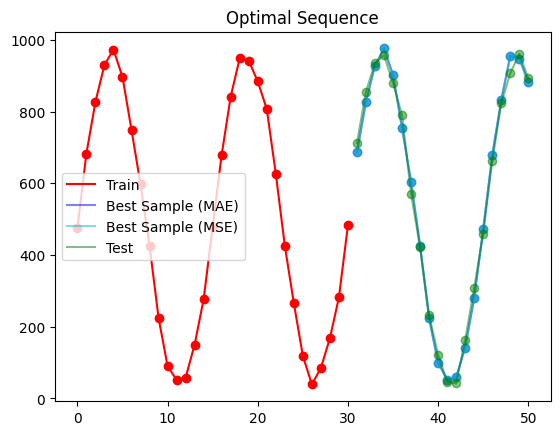

In [167]:
for sysPrompt in sysPrompts.values():
    generatedSamples = dataByPrompt[sysPrompt]
    print(generatedSamples)
    processedGeneratedSamples = [x[0:len(test)] for x in generatedSamples if len(x) >= len(test)]  # Truncate or discard samples based on 'test' length
    testNums = [int(strNum) for strNum in test]

    # Calculate Mean Absolute Error
    MAE = np.mean(np.abs(np.array(processedGeneratedSamples) - np.array(testNums)), axis=1)
    # Calculate Mean Squared Error
    MSE = np.mean((np.array(processedGeneratedSamples) - np.array(testNums))**2, axis=1)

    # Get the index of the best sample based on MAE
    bestSampleIndex_MAE = np.argmin(MAE)
    bestSample_MAE = processedGeneratedSamples[bestSampleIndex_MAE]

    # Get the index of the best sample based on MSE
    bestSampleIndex_MSE = np.argmin(MSE)
    bestSample_MSE = processedGeneratedSamples[bestSampleIndex_MSE]
    
    print(sysPrompt)
    print("Average MAE: ", np.mean(MAE))
    print("Average MSE: ", np.mean(MSE))

    print("Min MAE: ", MAE[bestSampleIndex_MAE])
    print("Min MSE: ", MSE[bestSampleIndex_MSE])

    def checkBounds(sample, upperBound=1000, lowerBound=0):
        for i in range(len(sample)):
            if sample[i] > upperBound or sample[i] < lowerBound:
                return True
        return False

    print("Fraction of samples with values outside of bounds: ", np.mean([checkBounds(sample) for sample in processedGeneratedSamples]))
    print("Fraction of samples with values outside of true bounds: ", np.mean([checkBounds(sample, upperBound=np.max([int(x) for x in test]), lowerBound=np.min([int(x) for x in test])) for sample in processedGeneratedSamples]))



    plt.plot(range(0, len(train)), [int(y) for y in train], 'r', label="Train")
    plt.plot(range(0, len(train)), [int(y) for y in train], 'ro')

    plt.plot(range(len(train), len(train) + len(bestSample_MAE)), bestSample_MAE, 'b', label="Best Sample (MAE)", alpha=0.5)
    plt.plot(range(len(train), len(train) + len(bestSample_MAE)), bestSample_MAE, 'bo', alpha=0.5)

    plt.plot(range(len(train), len(train) + len(bestSample_MSE)), bestSample_MSE, 'c', label="Best Sample (MSE)", alpha=0.5)
    plt.plot(range(len(train), len(train) + len(bestSample_MSE)), bestSample_MSE, 'co', alpha=0.5)

    test_data_range = range(len(train), len(train) + len(testNums))
    plt.plot(test_data_range, testNums, 'g', label="Test", alpha=0.5)
    plt.plot(test_data_range, testNums, 'go', alpha=0.5)
    plt.title("Optimal Sequence")
    plt.legend()
    plt.show()


# Load Data from ./savedData

#### For n=1000:

You are a helpful assistant that performs time series predictions on a sinusoidal signal. Please continue the following sequence without producing any additional text, just return the next twenty numbers.Generated values must progressively increase to start.
Average MAE:  387.37
Average MSE:  222876.33219999998
Min MAE:  14.05
Min MSE:  312.15
Fraction of samples with values outside of bounds:  0.077
Fraction of samples with values outside of true bounds:  0.795


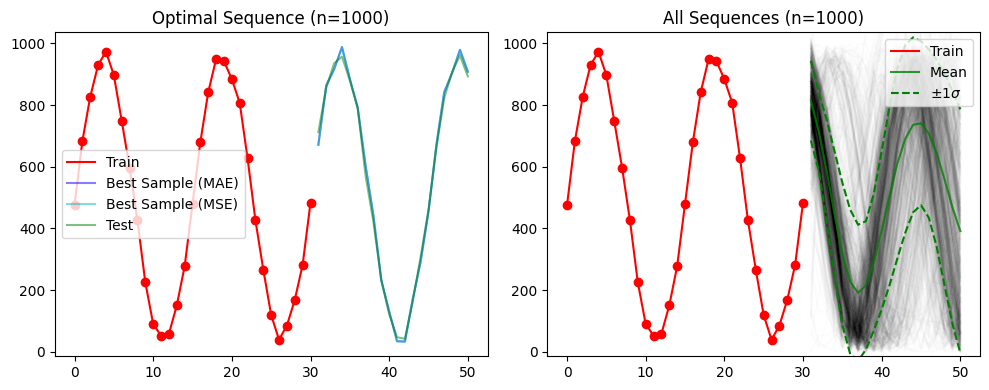

You are a helpful assistant that performs time series predictions on a sinusoidal signal. Please continue the following sequence without producing any additional text, just return the next twenty numbers.Generated values must progressively increase to start.
Average MAE:  441.3443
Average MSE:  266506.2573
Min MAE:  16.2
Min MSE:  385.5
Fraction of samples with values outside of bounds:  0.09
Fraction of samples with values outside of true bounds:  0.763


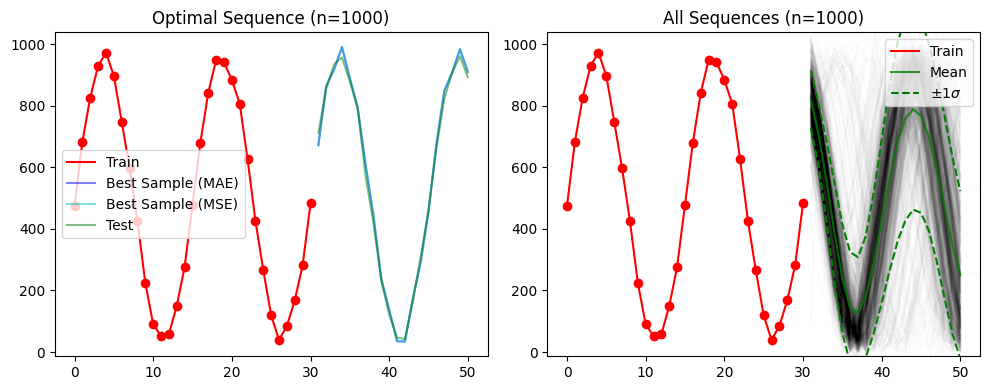

You are a helpful assistant that performs time series predictions on a sinusoidal signal. Please continue the following sequence without producing any additional text, just return the next twenty numbers.Generated values must progressively increase to start.
Average MAE:  377.57875
Average MSE:  231061.51025
Min MAE:  19.45
Min MSE:  502.15
Fraction of samples with values outside of bounds:  0.235
Fraction of samples with values outside of true bounds:  0.836


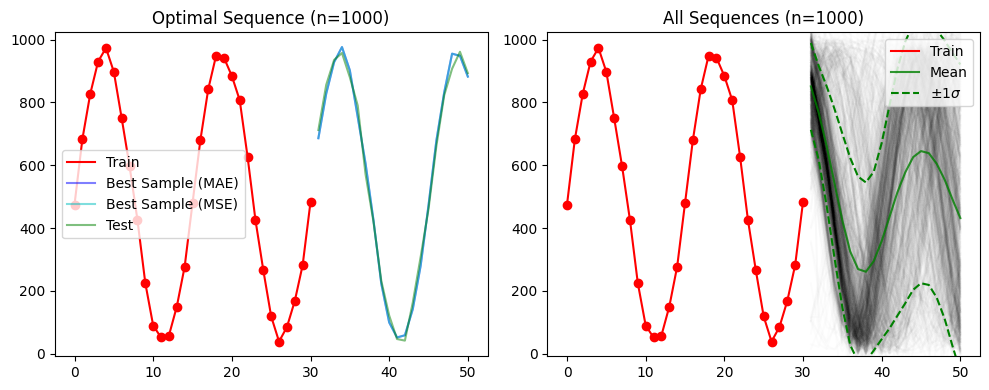

In [168]:

# for datafile in os.listdir("./savedData/"):
for datafile in ["NoInfoSineWave.csv","sineWave.csv","sineWavePhaseDescription.csv"]:
    data_list = []
    with open("./savedData/"+datafile, 'r') as file:
        for line in file:
            int_list = [int(number) for number in line.strip().split(',') if number != '' and number != ' ']
            data_list.append(int_list)
    data_list=data_list[0:1000]
    generatedSamples = data_list
    processedGeneratedSamples = [x[0:len(test)] for x in generatedSamples if len(x) >= len(test)]  # Truncate or discard samples based on 'test' length
    testNums = [int(strNum) for strNum in test]

    # Calculate Mean Absolute Error
    MAE = np.mean(np.abs(np.array(processedGeneratedSamples) - np.array(testNums)), axis=1)
    # Calculate Mean Squared Error
    MSE = np.mean((np.array(processedGeneratedSamples) - np.array(testNums))**2, axis=1)

    

    def checkBounds(sample, upperBound=1000, lowerBound=0):
        for i in range(len(sample)):
            if sample[i] > upperBound or sample[i] < lowerBound:
                return True
        return False
    
    # Get the index of the best sample based on MAE and MSE
    bestSampleIndex_MAE = np.argmin(MAE)
    bestSample_MAE = processedGeneratedSamples[bestSampleIndex_MAE]
    bestSampleIndex_MSE = np.argmin(MSE)
    bestSample_MSE = processedGeneratedSamples[bestSampleIndex_MSE]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    means = np.mean(processedGeneratedSamples, axis=0)
    std_devs = np.std(processedGeneratedSamples, axis=0)

    # First subplot with individual best cases
    ax1.plot(range(0, len(train)), [int(y) for y in train], 'r', label="Train")
    ax1.plot(range(0, len(train)), [int(y) for y in train], 'ro')
    ax1.plot(range(len(train), len(train) + len(bestSample_MAE)), bestSample_MAE, 'b', label="Best Sample (MAE)", alpha=0.5)
    # ax1.plot(range(len(train), len(train) + len(bestSample_MAE)), bestSample_MAE, 'bo', alpha=0.5)
    ax1.plot(range(len(train), len(train) + len(bestSample_MSE)), bestSample_MSE, 'c', label="Best Sample (MSE)", alpha=0.5)
    # ax1.plot(range(len(train), len(train) + len(bestSample_MSE)), bestSample_MSE, 'co', alpha=0.5)
    test_data_range = range(len(train), len(train) + len(testNums))
    ax1.plot(test_data_range, testNums, 'g', label="Test", alpha=0.5)
    # ax1.plot(test_data_range, testNums, 'go', alpha=0.5)
    ax1.set_title('Optimal Sequence (n=' + str(len(processedGeneratedSamples))+')')
    
    ax1.legend()
    ylim_ax1 = ax1.get_ylim()

  

    # Plot all sequences
    for sample in processedGeneratedSamples:
        ax2.plot(range(len(train), len(train) + len(sample)), sample, 'k', alpha=0.01)

    # Plot training data
    ax2.plot(range(0, len(train)), [int(y) for y in train], 'r', label="Train")
    ax2.plot(range(0, len(train)), [int(y) for y in train], 'ro')

    # Plot mean of all sequences
    ax2.plot(range(len(train), len(train) + len(means)), means, 'g', label="Mean", alpha=0.8)

    # Plot confidence bounds (mean +/- 1 std)
    # ax2.fill_between(range(len(train), len(train) + len(means)), means + std_devs, means - std_devs, color='k', alpha=0.1,label=r"$\pm 1 \sigma$")
    #instead of fill between just do two lines 
    ax2.plot(range(len(train), len(train) + len(means)), means + std_devs, 'g--', label=r"$\pm 1 \sigma$")
    ax2.plot(range(len(train), len(train) + len(means)), means - std_devs, 'g--')

    ax2.set_title('All Sequences (n=' + str(len(processedGeneratedSamples))+')')
    ax2.set_ylim(ylim_ax1)
    ax2.legend(loc='upper right')
    
    plt.tight_layout()


    print(sysPrompt)
    print("Average MAE: ", np.mean(MAE))
    print("Average MSE: ", np.mean(MSE))

    print("Min MAE: ", MAE[bestSampleIndex_MAE])
    print("Min MSE: ", MSE[bestSampleIndex_MSE])
    print("Fraction of samples with values outside of bounds: ", np.mean([checkBounds(sample) for sample in processedGeneratedSamples]))
    print("Fraction of samples with values outside of true bounds: ", np.mean([checkBounds(sample, upperBound=np.max([int(x) for x in test]), lowerBound=np.min([int(x) for x in test])) for sample in processedGeneratedSamples]))

    
    plt.show()